# Simulation Handling

Demonstrate the conversion of neutrino flux at Earth to observed hits in IceCube using the `asteria.handler.SimulationHandler` object.

In [1]:
%matplotlib inline

from asteria import config
from asteria.handler import SimulationHandler
from asteria.neutrino import Flavor
import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Setup styles for Plotting

In [2]:
def setup_plotting():
    axes_style =   {            'grid' : 'True',
                           'labelsize' : '24',
                            'labelpad' : '8.0' }
    
    xtick_style =  {       'direction' : 'out',
                           'labelsize' : '20.',
                          'major.size' : '5.',   
                         'major.width' : '1.',
                       'minor.visible' : 'True',
                          'minor.size' : '2.5',
                         'minor.width' : '1.' }
    
    ytick_style =  {       'direction' : 'out',
                           'labelsize' : '20.',
                          'major.size' : '5',   
                         'major.width' : '1.',
                       'minor.visible' : 'True',
                          'minor.size' : '2.5',
                         'minor.width' : '1.' }
    
    grid_style =   {           'alpha' : '0.75' }
    legend_style = {        'fontsize' : '18' }
    font_syle =    {            'size' : '20'}
    text_style =   {          'usetex' : 'True' }
    figure_style = {  'subplot.hspace' : '0.05' }
    
    mpl.rc(    'font', **font_syle )
    mpl.rc(    'text', **text_style )
    mpl.rc(    'axes', **axes_style )
    mpl.rc(   'xtick', **xtick_style )
    mpl.rc(   'ytick', **ytick_style )
    mpl.rc(    'grid', **grid_style )
    mpl.rc(  'legend', **legend_style )
    mpl.rc(  'figure', **figure_style )
    
    mpl.rcParams['text.usetex'] = True 
    mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
setup_plotting()

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [3]:
conf = config.load_config('../../data/config/default.yaml')

## Prepare Simulation Handler

Initialize the simulation handler using the `asteria.config.Configuration` object `conf`. The simulation handler contains its own configuration data member, which is also named `conf`. The information stored within may differ slightly with the information contained within the `asteria.config.Configuration` object used to initialize the handler, as the handler performs error checking during initialization. These differences will manifest in two forms.
1. If user provides "default" for any configuration option in the simulation node of the yaml configuration file (Other than the `energy` and `time` sub-nodes), the handler will convert this to a more informative string. This notebook uses configuration `default.yaml` which uses "default" for the `interactions` and `hierarchy` sub-nodes.  These members are accessed with `sim.conf.simulation.interactions` and `sim.conf.simulation.hierarchy`. The actual values of the handler's `conf` object are printed in the following cell.
2. If the user provides "None" or does not provide a value to the hierarchy sub-node, the handler will set the subnodes of its internal conf data member to the string 'none'.

The simulaiton configuration is printed in yaml-compatible format. This string can be used to populate the simulation sub-nodes of an ASTERIA configuration yaml file. These data are also accessible in the form of a dictionary of strings via calling `sim.conf_dict`.

In [4]:
sim = SimulationHandler(conf)
sim.print_config()

flavors:
    - nu_e
    - nu_e_bar
    - nu_x
    - nu_x_bar
interactions:
    - InvBetaPar
    - ElectronScatter
    - Oxygen16CC
    - Oxygen16NC
    - Oxygen18
hierarchy: normal
mixing:
    scheme: adiabatic-msw
    angle: 33.2 deg
energy:
    min: 0 MeV
    max: 100 MeV
    step: 0.1 MeV
    size: 1001
time:
    min: -1 s
    max: 1 s
    step: 1 ms
    size: 2001


Please refer to the `SimulationHandler` docstring for information about its data members

In [5]:
#print(SimulationHandler.__doc__)

## Compute Signal per DOM

For each flavor, compute the photonic energy deposition in one $m^3$ of ice, and then scale it to the effective volume of one DOM.

`sim.run()` first attempts to load a simulation from the file specified by the `IO.table.path` node of the configuration. See the following cells for a discussion of loading/saving simulations. If no simulation is loaded, `sim.run()` performs the simulation by sequentially calling `sim.compute_photon_spectra()` and `sim.compute_energy_per_volume()`.

 - `sim.compute_photon_spectra()` computes the spectrum of photons produced by neutrino interactions in the ice. This is accessible in data member `sim.photon_spectra` in the form of a numpy array of shape `(len(sim.flavors), len(sim.Enu))` In the case of this example `(4, 1001)`. This method must be called before `sim.compute_energy_per_volume()`. 
 
 - `sim.compute_energy_per_volume()` Computes the flux at the detector, considering oscillations, before computing the energy deposition per cubic meter in the ice due to photons produced by neutrino interactions in the ice. This is accessible in data member `sim.E_per_V` in the form of a numpy array of shape `(len(sim.flavors), len(sim.time))` In the case of this example `(4, 2001)`. 
 

For a more detailed description of this calculation, please see the `detector_response.ipynb` notebook.

If the argument `load_simulation=False` is provided, then no attempt to load a simulation will be made, and `sim.run()` will perform the simulation.

In [6]:
sim.run(load_simulation=False)

effvol = 0.1654 * u.m**3 / u.MeV #Simple estimation of IceCube DOM Eff. Vol.
signal_per_DOM = effvol * sim.E_per_V 

Running Simulation...
Beginning nu_e simulation...       Completed
Beginning nu_e_bar simulation...   Completed
Beginning nu_x simulation...       Completed
Beginning nu_x_bar simulation...   Completed


## Save/Load Simulation to/from File

The photonic energy per volume is the quantity that is most computationally difficult to obtain, and can be used to obtain numerous high level results. Saving this information to file enables faster processing for large scale analysis. Additionally, this information scales according to `progenitor_distance`$^{-2}$, so multiple simulations at different distances can be loaded from the same file and scaled accordingly. 

`sim.save()` wraps `asteria.IO.save()` and writes the energy per volume is stored to the file specified in the configuration file under the `IO.table.path` node. In this case, the file `\data\processed\nakazato-shen-z0.02-t_rev300ms-s13.0.h5` is used. The actual result saved by `sim.save()` is the photonic energy per distance scaled to a progenitor 1kpc away. Note that the user must perform this scaling manually if only using `IO.save()`.

If the a simulation with the same configuration already exists in`\data\processed\nakazato-shen-z0.02-t_rev300ms-s13.0.h5`, trying to save the simulation will cause `asteria.IO.save()` to throw an exception, which is handled below with a `try-except` block. This may be bypassed by using the force argument, which will force `asteria.IO.save()` to overwrite the existing data.

```sim.save(conf, force=True)```

Similarly, `sim.load()` wraps `asteria.IO.load()`, and returns the energy per volume scaled to the distance specified in the configuration yaml file under the `source.progenitor.distance.distance` node. Note that `IO.load()` on its own does not perform this scaling. See the file `\docs\nb\load_simulation.ipynb` for information on reading the simulation result from file. The loaded data takes the form of a numpy array of shape `(len(sim.flavors), len(sim.time))` In the case of this example `(4, 2001)`.

In [7]:
try:
    sim.save()
except FileExistsError as e:
    print(e)

Found  0
Simulation exists, Aborting. Use argument 'force = True' to force saving.


## Define Helper Functions

Define Functions for plotting, retrieving information from ROOT Files

- `rebin` Reshape the independent variable `var` with resolution `old_binning` and dependent variable `data` (assumed to be numpy array) and return new arrays `var` and `data` with resolution `new_binning`.

- `bin_hits` using the `detector` table of DOMs and their properties, determines the number of hits within the specified binning `binning`. This takes into account the artificial deadtime of the DOMs.




In [8]:
def rebin(var, data, old_binning, new_binning):
    step = int(new_binning/old_binning)
    new_size = int(data.size / step)
    rebinned_data = np.array([np.sum(data_part) for data_part in np.array_split( data, new_size )])
    rebinned_var  = var.value[int(0.5 * step)::step]
    
    return rebinned_var, rebinned_data  

def bin_hits(detector, time, total_E_per_V, dt, binning):
    doms = detector.doms_table()
    n_i3_doms = len(doms[doms['type'] == 'i3'])
    n_dc_doms = len(doms[doms['type'] == 'dc'])

    deadtime = detector.deadtime
    dc_rel_eff = detector.dc_rel_eff

    i3_dom_bg_mu = detector.i3_dom_bg_mu
    i3_dom_bg_sig = detector.i3_dom_bg_sig

    dc_dom_bg_mu = detector.dc_dom_bg_mu
    dc_dom_bg_sig = detector.dc_dom_bg_sig
    
    time_binned, total_E_per_V_binned = rebin(time, total_E_per_V, dt, binning)
    eps_i3 = 0.87 / (1+deadtime*total_E_per_V_binned/binning)
    eps_dc = 0.87 / (1+deadtime*total_E_per_V_binned*dc_rel_eff/binning)
    hits_binned = detector.detector_hits(total_E_per_V_binned, eps_i3, eps_dc)

    sn_bg_mu  = (n_i3_doms*i3_dom_bg_mu + n_dc_doms*dc_dom_bg_mu ) * binning;
    sn_bg_sig = np.sqrt( (n_i3_doms*i3_dom_bg_sig**2 + n_dc_doms*dc_dom_bg_sig**2) * binning )
    bg_binned = np.random.normal(sn_bg_mu, sn_bg_sig, time_binned.size)
   
    return time_binned, bg_binned, hits_binned

## Plot Expected Signal Increase for Each Flavor
This will plot the signal increase in a single DOM caused by each flavor. The curve shows the DOM response from 0.05 seconds before the core bounce to 0.65 seconds after the core bounce. Note that this is computed with the assumption that the effective volume of the DOM is 0.1654 m$^3$ MeV$^{-1}$

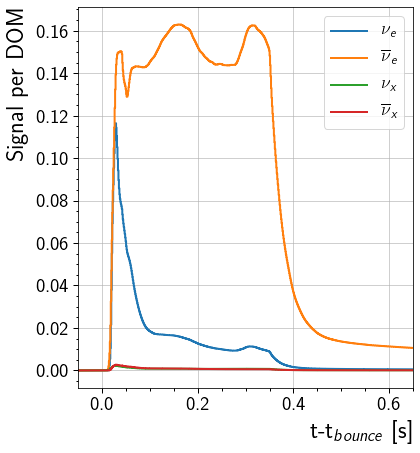

In [9]:
fig, ax = plt.subplots(1, figsize = (6,7))

for nu, flavor in enumerate(sim.flavors):
    ax.step( sim.time, signal_per_DOM[nu], label=flavor.to_tex(), linewidth=2)
    
ax.set_ylabel('Signal per DOM', horizontalalignment='right', y = 1)
ax.set_xlabel(r't-t$_{bounce}$ [s]', horizontalalignment='right', x=1.0)
ax.set(xlim=(-0.05, 0.65))
ax.legend()

## Plot Expected Signal Increase in Detector
This will plot the signal increase across the entire detector. The curve shows the DOM response from 0.05 seconds before the core bounce to 0.65 seconds after the core bounce.

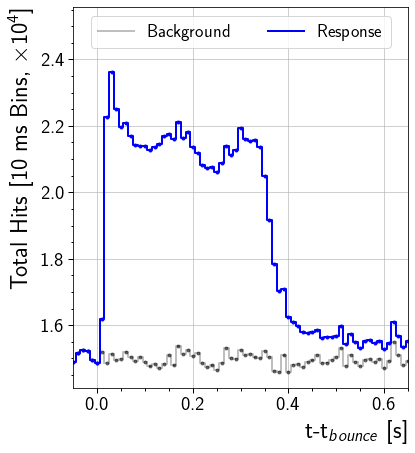

In [10]:
sn_dt = 0.01 #Units seconds: 10ms binning for plotting
time, background, signal = bin_hits(sim.detector, sim.time, sim.total_E_per_V.value, sim.dt.value, sn_dt)

# Scaled to improve readability of axis labels
background = background/1e4
signal = signal/1e4
response = background+signal

fig, ax = plt.subplots(1, figsize = (6,7))
ax.step(time, background , lw=2, label='Background', color='k', alpha=0.25)[0] 
h = ax.step(time, response, lw=2, label='Response', color='b')[0]  
# Error bars are computed on unscaled quantity and then scaled.
ax.errorbar(time - 0.5*sn_dt, background, yerr=np.sqrt(background)/1e4, color='k', alpha=0.5, fmt='.')
ax.errorbar(time - 0.5*sn_dt, response, yerr=np.sqrt(response)/1e4, color=h.get_color(), fmt='.')

ylimits = ax.get_ylim()
ax.set(xlim=(-0.05, 0.65), ylim=(ylimits[0], ylimits[1]+0.15))
ax.set_xlabel(r't-t$_{bounce}$ [s]', horizontalalignment='right', x=1.0)
ax.set_ylabel(r'Total Hits [10 ms Bins, $\times 10^4$]', horizontalalignment='right', y=1.0)
l = ax.legend(loc='upper center', ncol=2)